# Лабораторная работа №4

### Восстановление плотности
Метод ядерного сглаживания

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from scipy.stats import gaussian_kde
from sklearn.mixture import GaussianMixture
from scipy.stats import entropy

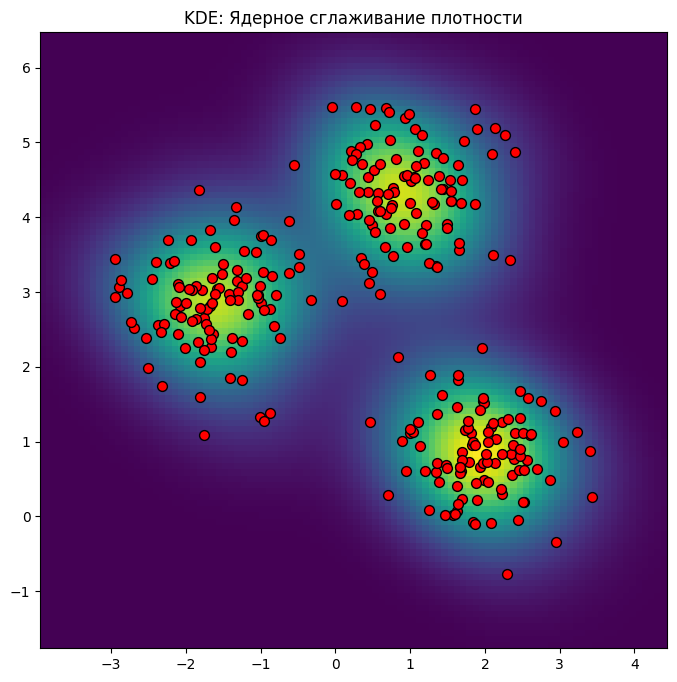

In [2]:
np.random.seed(42)
X, _ = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=0)

# Ядерное сглаживание
kde = gaussian_kde(X.T)

# Сетка точек для визуализации оцененной плотности
xmin, xmax = X[:, 0].min() - 1, X[:, 0].max() + 1
ymin, ymax = X[:, 1].min() - 1, X[:, 1].max() + 1
Xgrid, Ygrid = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([Xgrid.ravel(), Ygrid.ravel()])
Z = np.reshape(kde(positions).T, Xgrid.shape)

# Визуализация
plt.figure(figsize=(12, 8))
plt.imshow(np.rot90(Z), cmap=plt.cm.viridis,
           extent=[xmin, xmax, ymin, ymax])
plt.scatter(X[:, 0], X[:, 1], c='r', s=50, edgecolor='k')
plt.title("KDE: Ядерное сглаживание плотности")
plt.show()

Метод максимума ожидания (EM)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.9 is maybe too old for this OS.
  warnings.warn(


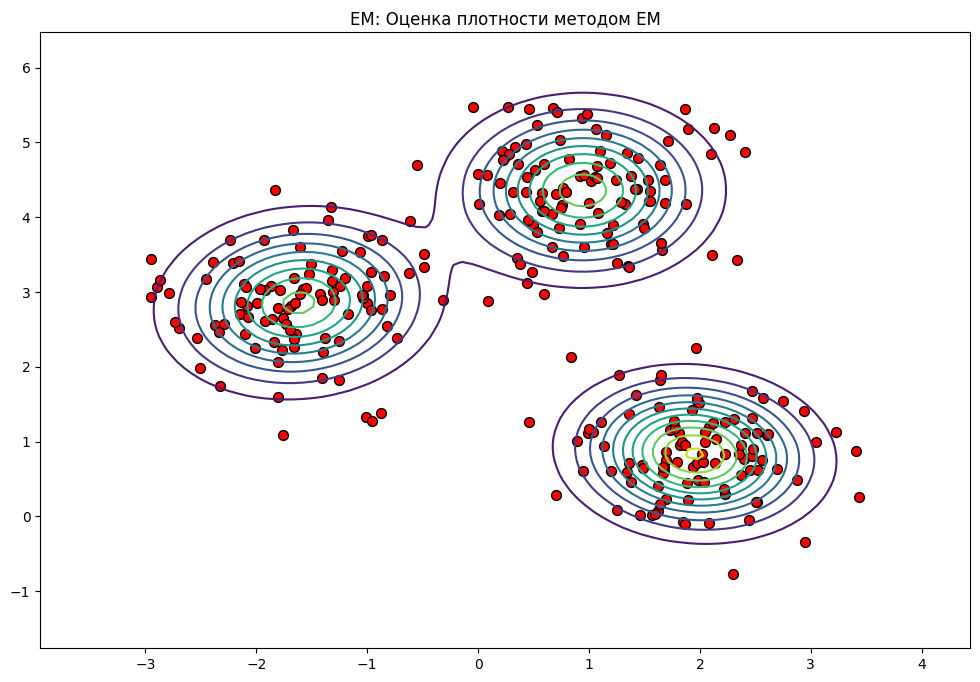

In [3]:
gmm = GaussianMixture(n_components=3, random_state=0)
gmm.fit(X)

# Оценка плотности
x, y = np.meshgrid(np.linspace(xmin, xmax, 100),
                   np.linspace(ymin, ymax, 100))
Xgrid_flat = np.c_[x.ravel(), y.ravel()]
Z = np.exp(gmm.score_samples(Xgrid_flat))
Z = Z.reshape(x.shape)

# Визуализация
plt.figure(figsize=(12, 8))
plt.contour(x, y, Z, levels=15, cmap='viridis')
plt.scatter(X[:, 0], X[:, 1], c='r', s=50, edgecolor='k')
plt.title("EM: Оценка плотности методом EM")
plt.show()

### Реализация метода Метрополиса-Гастингса

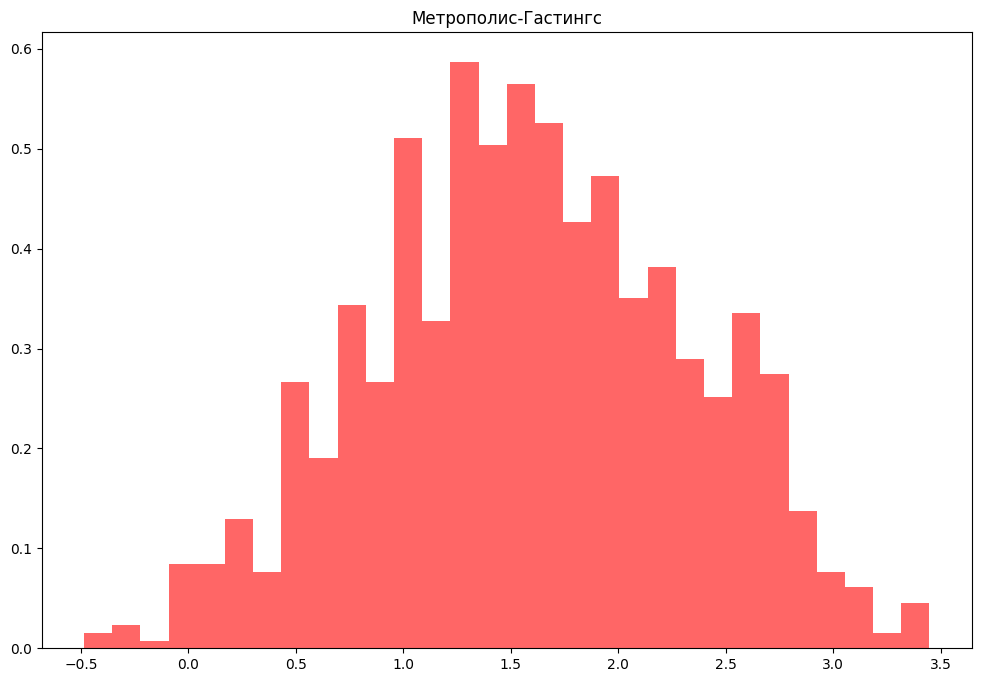

In [4]:
def metropolis_hastings(p, q_draw, q_pdf, n_samples, x_init):
    samples = []
    x = x_init

    for _ in range(n_samples):
        x_new = q_draw(x)
        acceptance = p(x_new) * q_pdf(x, x_new) / (p(x) * q_pdf(x_new, x))
        if np.random.rand() < acceptance:
            x = x_new
        samples.append(x)

    return np.array(samples)

# Простая гауссовская цель
target_density = lambda x: np.exp(-0.5 * ((x - 1.5) / 0.75) ** 2) / (np.sqrt(2 * np.pi) * 0.75)

# Пример предложения: гауссовское случайное блуждание
proposal_draw = lambda x: np.random.normal(x, 0.5)
proposal_density = lambda x, y: np.exp(-0.5 * ((x - y) / 0.5) ** 2) / (np.sqrt(2 * np.pi) * 0.5)

mh_samples = metropolis_hastings(target_density, proposal_draw, proposal_density, 1000, 0)

plt.figure(figsize=(12, 8))
plt.hist(mh_samples, bins=30, density=True, alpha=0.6, color='r')
plt.title("Метрополис-Гастингс")
plt.show()

### Метод Гиббса

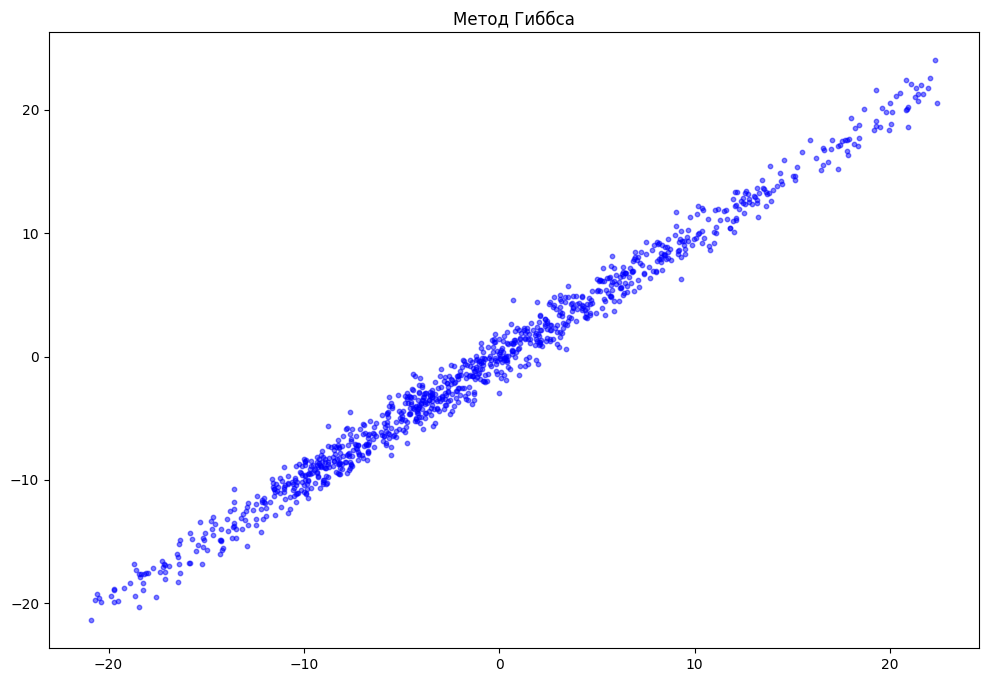

In [5]:
def gibbs_sampler(n_samples, burn_in=100):
    samples = np.zeros((n_samples, 2))
    x, y = 0, 0
    for i in range(n_samples + burn_in):
        x = np.random.normal(y, 1)
        y = np.random.normal(x, 1)
        if i >= burn_in:
            samples[i - burn_in] = [x, y]
    return samples

gibbs_samples = gibbs_sampler(1000)

plt.figure(figsize=(12, 8))
plt.scatter(gibbs_samples[:, 0], gibbs_samples[:, 1], alpha=0.5, c='b', s=10)
plt.title("Метод Гиббса")
plt.show()

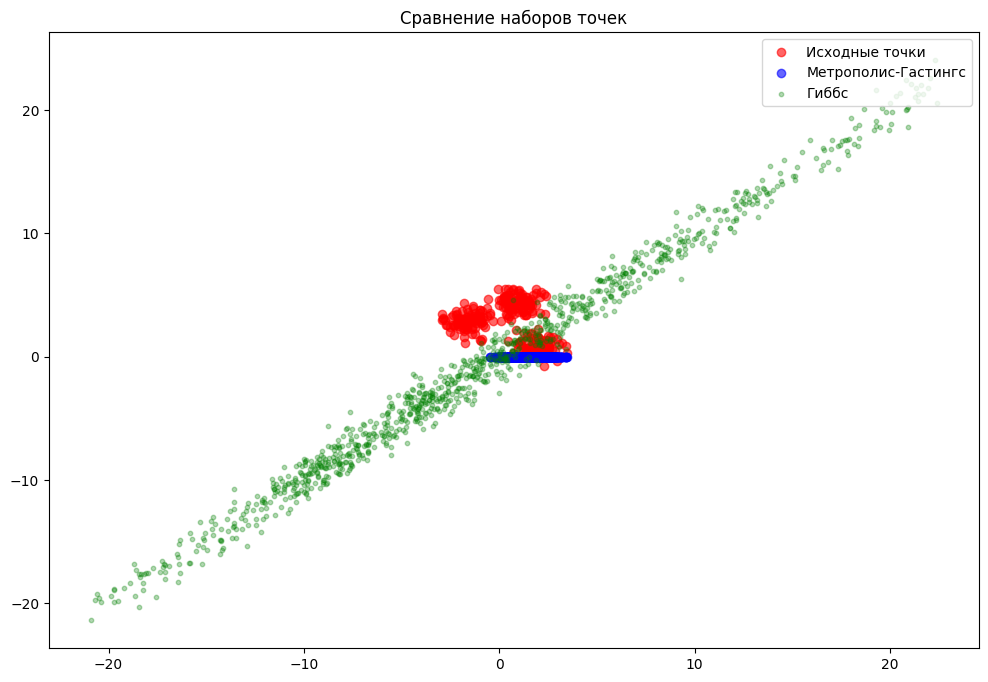

In [6]:
plt.figure(figsize=(12, 8))
plt.scatter(X[:, 0], X[:, 1], alpha=0.6, c='r', label='Исходные точки')
plt.scatter(mh_samples, np.zeros_like(mh_samples), alpha=0.6, c='b', label='Метрополис-Гастингс')
plt.scatter(gibbs_samples[:, 0], gibbs_samples[:, 1], alpha=0.3, c='g', label='Гиббс', s=10)
plt.legend(loc='upper right')
plt.title("Сравнение наборов точек")
plt.show()

### Оценка KL-дивергенции

In [7]:
# Получение оценки плотности для сравнения
hist_og, bins_og = np.histogram(X[:, 0], bins=30, density=True)
hist_mh, _ = np.histogram(mh_samples, bins=bins_og, density=True)

# KL-дивергенция
kl_divergence = entropy(hist_og + 1e-10, hist_mh + 1e-10)
print(f"KL-дивергенция: {kl_divergence}")

KL-дивергенция: 6.564421132282547


### Опционы 3D визуализации для Метрополиса-Гастингса

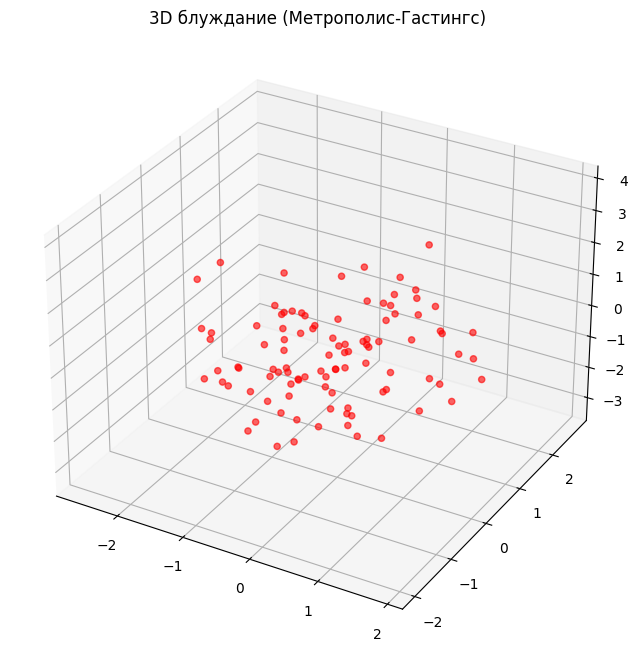

In [10]:
np.random.seed(42)  # для воспроизводимости

mh_samples = np.random.normal(0, 1, (100, 2))

# Добавление третьей составляющей
mh_samples_3d = np.c_[mh_samples, np.random.normal(0, 1, mh_samples.shape[0])]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mh_samples_3d[:, 0], mh_samples_3d[:, 1], mh_samples_3d[:, 2], c='r', alpha=0.6)
ax.set_title("3D блуждание (Метрополис-Гастингс)")
plt.show()